# 6.3 순환 신경망의 고급 사용법

이 절에서는 순환 신경망의 고급 사용법을 기온 예측 문제를 통해 설명함

### 순환 신경망의 성능과 일반화 능력을 향상시키기 위한 3가지 고급 기법

1. **순환 드롭아웃(recurrent dropout)**

    순환 층에서 overfitting을 방지


2. **스태킹 순환 층(stacking recurrent layer)**

    네트워크의 표현 능력(representation power)을 증가시킴(계산비용도 증가)


3. **양방향 순환 층(bidirectional recurrent layer)**

    정확도를 높이고 기억을 좀 더 오래 유지시킴

## 6.3.1 기온 예측 문제

- 날씨 시계열 데이터셋
    - `$ wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip`
- 마지막 데이터 포인트에서 24시간 이후의 온도를 예측하는 문제
- 시계열 데이터에서 일반적으로 나타나는 여러가지 어려운 점을 가지고 있음

In [1]:
# 데이터셋 분석

import os 

data_dir = './datasets/climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')


# f = open(fname)
# data = f.read()
# f.close()
with open(fname) as f:
    data = f.read()
    

lines = data.split('\n')
headers = lines[0].split(',')
lines = lines[1:]

print("총 데이터 수 :", len(lines))
print(headers)

총 데이터 수 : 420551
['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


In [2]:
# numpy array로 바꾸기

import numpy as np

# "Date Time" column 제외
float_data = np.zeros((len(lines), len(headers)-1))

for i, line in enumerate(lines):
    float_data[i, :] = [float(x) for x in line.split(',')[1:]]
    
print(float_data.shape)
print(float_data[0])

(420551, 14)
[ 9.96520e+02 -8.02000e+00  2.65400e+02 -8.90000e+00  9.33000e+01
  3.33000e+00  3.11000e+00  2.20000e-01  1.94000e+00  3.12000e+00
  1.30775e+03  1.03000e+00  1.75000e+00  1.52300e+02]


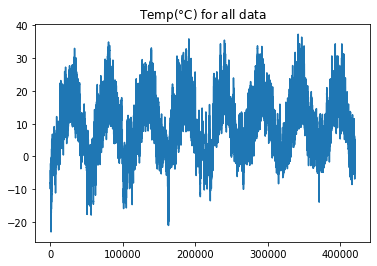

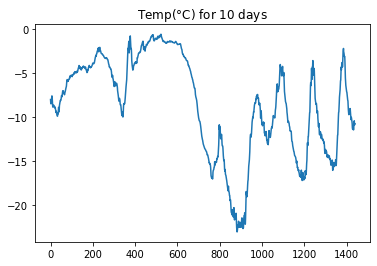

In [3]:
# 온도(섭씨) 데이터 그래프 그리기

import matplotlib.pyplot as plt

# 전체 온도 데이터
temp = float_data[:, 1]
plt.plot(range(len(temp)), temp)
plt.title("Temp($\degree$C) for all data")

plt.figure()

# 첫 10일간의 온도
temp = float_data[:1440, 1]
plt.plot(range(len(temp)), temp)
plt.title("Temp($\degree$C) for 10 days")

plt.show()

#### 그래프 분석
- 전체 데이터
    - 연간 온도에 주기성이 있고 안정적임
    - **연간 데이터는 안정적이므로 지난 몇 달간의 데이터로 다음 달의 평균 온도를 예측하기는 쉬움**
- 10일간 데이터
    - 일별 온도에 주기성이 있지만 불안정함(마지막 4일간만 그나마 안정적으로 보임)
    - **일간 데이터는 불안정적이므로 다음 날의 온도 예측은 어려움**

## 6.3.2 데이터 준비

기온 예측 문제를 정확히 정의하면 다음과 같음

> 10일간의 데이터를 바탕으로 다음 날(11일 째)의 온도를 예측하기

위 문제를 3가지 변수를 통해 다시 정의하면 다음과 같음

> `lookback` 타임스텝만큼 이전으로 돌아가서 매 `steps` 타임스텝마다 샘플링을 하고 이를 바탕으로 `delay` 타임스텝 이후의 온도를 예측하기
- `lookback=1440` : 10일 전
- `steps=6` : 1시간 간격으로 데이터 포인트를 샘플링
- `delay=144` : 24시간이 지난 데이터가 타깃


### 데이터 전처리

위에서 정확히 정의한 문제를 처리하기 위해 해야할 2가지 데이터 전처리

1. 데이터 정규화
    - 이미 수치형으로 되어있으므로 벡터화는 불필요
    - 각 feature별 데이터 스케일만 정규화해주면 됨(표준정규분포 형태로)
    
    
2. 원하는 형태로의 데이터 주입을 위한 파이썬 제너레이터

In [3]:
# 1. 데이터 정규화

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# scaler.fit(float_data2)
# print(scaler.mean_)
# print(scaler.std_)
# scaler.transform(float_data2)
# print(float_data2[0])

In [4]:
# 2. 파이썬 제너레이터

def generator(data, lookback, delay, step=6, 
              shuffle=False, batch_size=128):
    min_idx = 0
    max_idx = len(data)-delay-1
    
    i = min_idx + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(i, max_idx, batch_size)
        else:
            if (i+batch_size) >= max_idx:
                rows = np.arange(i, max_idx)
                i = min_idx + lookback
                
            else:
                rows = np.arange(i, i+batch_size)
                i += batch_size
                
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            samples[j] = data[range(rows[j]-lookback, rows[j], step)]
            targets[j] = data[rows[j]+delay][1]
            
        yield samples, targets

In [5]:
lookback = 1440 
delay = 144
step = 6
batch_size = 128

train_gen = generator(float_data[:200000],
                      lookback=lookback,
                      delay=delay,
                      step=step,
                      shuffle=True,
                      batch_size=batch_size)

val_gen = generator(float_data[200000:300000],
                    lookback=lookback,
                    delay=delay,
                    step=step,
                    batch_size=batch_size)

test_gen = generator(float_data[300000:],
                     lookback=lookback,
                     delay=delay,
                     step=step,
                     batch_size=batch_size)

val_steps = int(np.ceil((300000-200000-lookback-delay-1)/batch_size))
test_steps = int(np.ceil((len(float_data)-300000-lookback-delay-1)/batch_size))

print(val_steps, test_steps)

769 930


## 6.3.3 상식 수준의 기준점

- 머신러닝 모델이 잘 동작하는지 평가하기 위한 최소한의 기준으로 상식 수준의 기준점을 만듦


- 온도 시계열 데이터는 연속성이 있고 일자별로 주기성을 가진다고 가정하면(오늘 온도는 내일 온도와 비슷함) 아래와 같이 기준을 잡을 수 있음

> 24시간 후의 온도는 현재의 온도와 같다

- 위 기준에 대해 평균 절댓값 오차(MAE)로 평가

In [7]:
# 상식 기준의 mae 계산

def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(targets - preds))
        batch_maes.append(mae)
    
    return (np.mean(batch_maes))

print("MAE :", evaluate_naive_method())

# 정규화 된 데이터라서 와닿지 않으므로 온도의 표준편차를 곱해줌
# 평균 절댓값 오차 : 약 섭씨 2.56도 정도
print("MAE(섭씨) :", evaluate_naive_method()*std[1])

MAE : 0.2897150610944221
MAE(섭씨) : 2.564702312439227


- 따라서 우리가 만들 머신러닝 모델은 2.56도의 오차보다 더 적은 온도차를 예측해야함

## 6.3.4 기본적인 머신 러닝 방법

### 간단한 머신러닝 모델

- RNN과 같은 복잡하고 연산비용이 많이 드는 모델을 바로 시도하기 전에 간단하고 쉬운 머신러닝 모델(FCN)을 만들어 테스트 해보는 것이 좋음


- 이는 복잡한 모델을 도입하는 근거를 마련해주기 때문(굳이 안복잡해도 되는데 복잡하게 접근하는 경우가 생길 수 있음)


- 손실함수는 MAE로 상식 수준의 모델과 비교할 수 있게 설정

In [8]:
from tensorflow.keras import models, layers, optimizers

input_shape = (lookback//step, float_data.shape[-1])

model = models.Sequential()

model.add(layers.Flatten(input_shape=input_shape))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3360)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                107552    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 107,585
Trainable params: 107,585
Non-trainable params: 0
_________________________________________________________________


In [9]:
model.compile(loss='mae',
              optimizer=optimizers.RMSprop())

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 11s 22ms/step - loss: 1.8111 - val_loss: 0.9959
Epoch 2/20
500/500 [==============================] - 11s 22ms/step - loss: 0.6641 - val_loss: 0.3447
Epoch 3/20
500/500 [==============================] - 11s 21ms/step - loss: 0.3338 - val_loss: 0.3176
Epoch 4/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2813 - val_loss: 0.3790
Epoch 5/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2619 - val_loss: 0.3288
Epoch 6/20
500/500 [==============================] - 10s 21ms/step - loss: 0.2504 - val_loss: 0.3201
Epoch 7/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2414 - val_loss: 0.3186
Epoch 8/20
500/500 [==============================] - 11s 21ms/step - loss: 0.2354 - val_loss: 0.3289
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2326 - val_loss: 0.3086
Epoch 10/20
500/500 [=================

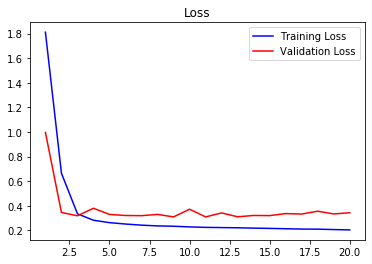

In [10]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'b', label="Training Loss")
plt.plot(epochs, val_loss, 'r', label="Validation Loss")
plt.title("Loss")
plt.legend()

plt.show()

#### 결과 분석
- 기준점 MAE(약 0.28)에 가깝게 다가가긴 하지만 안정적이지 못함
- 기준 모델의 성능을 앞지르기가 쉽지 않음


#### 상식 수준의 기준 모델보다 성능이 높지 못한 이유
- 모델의 가설 공간은 매우 복잡함
- 학습 알고리즘이 특정 종류의 간단한 모델을 찾도록 하드코딩 된 것이 아니라면 상식 수준의 방법과 같은 간단한 해결책은 찾지 못할 수 있음(이것이 일반적으로 머신러닝이 가진 심각한 제약사항)

## 6.3.5 첫 번째 순환 신경망

- 6.3.4절의 간단한 머신러닝 모델은 잘 동작하지 않았음(시간 개념을 고려 X)
- 시간 개념을 고려하는 순환 시퀀스 처리 모델로 다시 시도


- LSTM 대신에 GRU로 시도 (LSTM이 더 표현학습 능력이 좋아서 잘 될수도 있음(계산비용과 표현학습능력 사이의 trade-off))

In [11]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()

model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 32)                4608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer=optimizers.RMSprop(), loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 23s 47ms/step - loss: 0.3076 - val_loss: 0.2696
Epoch 2/20
500/500 [==============================] - 19s 39ms/step - loss: 0.2845 - val_loss: 0.2715
Epoch 3/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2754 - val_loss: 0.2637
Epoch 4/20
500/500 [==============================] - 17s 35ms/step - loss: 0.2712 - val_loss: 0.2651
Epoch 5/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2657 - val_loss: 0.2670
Epoch 6/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2603 - val_loss: 0.2662
Epoch 7/20
500/500 [==============================] - 19s 38ms/step - loss: 0.2563 - val_loss: 0.2694
Epoch 8/20
500/500 [==============================] - 17s 34ms/step - loss: 0.2527 - val_loss: 0.2656
Epoch 9/20
500/500 [==============================] - 18s 37ms/step - loss: 0.2482 - val_loss: 0.2693
Epoch 10/20
500/500 [=================

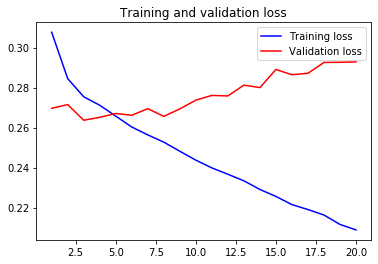

In [13]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 결과 분석
- 간단한 머신러닝 모델의 MAE보다 적은 검증 손실(MAE)을 보였음
- 시퀀스 데이터에서는 순환 네트워크가 완전 연결 네트워크보다 좋다는 것이 증명됨!


- 상식 수준 모델의 MAE보다 조금 낫긴 하지만 더 개선할 수 있을 것 같음
- Overfitting이 일어남

## 6.3.6 과대적합을 감소하기 위해 순환 드롭아웃 사용하기

### 순환 신경망의 Dropout

**순환 층에 dropout을 적용하려면, 모든 타임스텝에 동일한 dropout mask를 적용해야 함** (순환 층 이전에 dropout을 적용하면 regularization을 통한 도움보다 학습에 더 방해가 됨)

이는 순환층 내부 계산에 사용된 활성화 함수에 타임스텝마다 동일한 dropout mask를 적용해야 한다는 것을 뜻하며 모든 타임스텝에 동일한 dropout mask가 적용되면 네트워크가 오차를 타임스텝에 걸쳐서 적절하게 전파시키게 됨

### 케라스의 2가지 순환 층 Dropout 

케라스의 모든 순환층에서는 2개의 매개변수로 이를 적용할 수 있음

- `dropout`
    - 층의 입력에 대한 dropout 비율
    - LSTM과 GRU의 pseudo code에서 `input_t`
- `recurrent_dropout`
    - 순환 상태의 dropout 비율
    - LSTM과 GRU의 pseudo code에서 `state_t`
    


- 주의) LSTM의 경우, 아래 pseudo code에서 4개(`output_t`, `i_t`, `f_t`, `k_t`)의 `input_t`, `state_t`에 각기 다른 dropout mask가 적용됨
~~~
output_t = activation(c_t) * activation(dot(input_t, Wo) + dot(state_t, Uo) + bo)
i_t = activation(dot(input_t, Wi) + dot(state_t, Ui) + bi)
f_t = activation(dot(input_t, Wf) + dot(state_t, Uf) + bf)
k_t = activation(dot(input_t, Wk) + dot(state_t, Uk) + bk)
~~~

- 주의) GRU의 경우, 아래 pseudo code에서 3개(`z_t`, `r_t`, `g_t`)의 
`input_t`, `state_t`에 각기 다른 dropout mask가 적용됨 (`output_t`의 `state_t`에는 dropout mask 미적용)

~~~
output_t = z_t x state_t + (1 - z_t) x g_t

z_t = sigmoid(dot(state_t, Uz) + dot(input_t, Wz) + bz)
r_t = sigmoid(dot(state_t, Ur) + dot(input_t, Wr) + br)
g_t = tanh(dot(r_t x state_t, Ug) + dot(input_t, Wg) + bg)
~~~

In [40]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()

# 책에서는 GRU로 되어있는데 GRU로 Recurrent_dropout 0.1이상 적용시 loss가 수렴X
# model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2, 
#                       input_shape=(None, float_data.shape[-1])))


# LSTM으로 하면 책처럼 어느정도 나와서 LSTM으로 진행
model.add(layers.LSTM(32, dropout=0.2, recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))

model.add(layers.Dense(1))

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 32)                6016      
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 33        
Total params: 6,049
Trainable params: 6,049
Non-trainable params: 0
_________________________________________________________________


In [41]:
model.compile(optimizer=optimizers.RMSprop(), loss='mae')

# dropout을 적용한 network의 경우, 수렴하는데 오래 걸리므로, epoch을 두배로 늘렸음
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 78s 157ms/step - loss: 0.3390 - val_loss: 0.2782
Epoch 2/40
500/500 [==============================] - 76s 153ms/step - loss: 0.3112 - val_loss: 0.2740
Epoch 3/40
500/500 [==============================] - 78s 156ms/step - loss: 0.3059 - val_loss: 0.2713
Epoch 4/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2996 - val_loss: 0.2703
Epoch 5/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2973 - val_loss: 0.2673
Epoch 6/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2921 - val_loss: 0.2750
Epoch 7/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2934 - val_loss: 0.2682
Epoch 8/40
500/500 [==============================] - 77s 154ms/step - loss: 0.2890 - val_loss: 0.2691
Epoch 9/40
500/500 [==============================] - 77s 155ms/step - loss: 0.2866 - val_loss: 0.2829
Epoch 10/40
500/500 [========

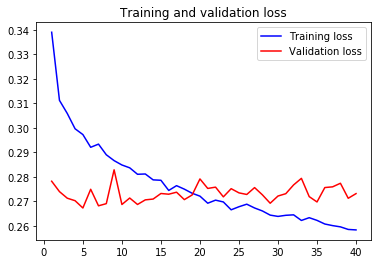

In [42]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 결과 분석

- Overfitting은 줄어듦
- loss가 크게 줄어들지 않은 것으로 보아 성능상의 병목이 있는 것 처럼 보임

## 6.3.7 스태킹 순환 층

- 성능상의 병목이 있는 것 같으므로, 네트워크의 용량을 늘려야 함

- 스태킹 순환 층이랑 네트워크 용량을 키우기 위해 순환 층을 쌓는 것을 말함


### 네트워크 용량 키우기

- 일반적인 머신러닝 작업 흐름에서 (dropout등을 사용해 overfitting을 줄이는 등의)기본 단계를 거쳤다고 가정하면 많은 과대적합이 될 때 까지 네트워크의 용량을 키워야 함

- **너무 많은 과대적합이 되지 않으면, 네트워크가 충분한 용량에 도달하지 못한 것**


In [6]:
from tensorflow.keras import models, layers, optimizers

model = models.Sequential()

# 마찬가지로 책과 비슷한 결과를 위해 GRU가 아닌 LSTM으로 진행

# 순환 층을 쌓기 위해 return_sequences=True 설정
model.add(layers.LSTM(32, dropout=0.1, recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))

# 책의 코드에서처럼 activation='relu'를 적용하니 또 loss가 매우 큰 값이 나옴
# 참고) LSTM과 GRU의 activation 기본 값
#      activation='tanh'
#      recurrent_activation='sigmoid'

# model.add(layers.LSTM(64, dropout=0.1, 
#                       activation='relu', recurrent_dropout=0.5))

# 그래서 activation은 기본값으로 두고 진행
model.add(layers.LSTM(64, dropout=0.1, recurrent_dropout=0.5))

model.add(layers.Dense(1))

In [7]:
model.compile(optimizer=optimizers.RMSprop(), loss='mae')

history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=40,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/40
500/500 [==============================] - 143s 287ms/step - loss: 0.3551 - val_loss: 0.2846
Epoch 2/40
500/500 [==============================] - 140s 281ms/step - loss: 0.3226 - val_loss: 0.2820
Epoch 3/40
500/500 [==============================] - 140s 281ms/step - loss: 0.3121 - val_loss: 0.2753
Epoch 4/40
500/500 [==============================] - 140s 281ms/step - loss: 0.3069 - val_loss: 0.2695
Epoch 5/40
500/500 [==============================] - 140s 281ms/step - loss: 0.3006 - val_loss: 0.2719
Epoch 6/40
500/500 [==============================] - 141s 281ms/step - loss: 0.2955 - val_loss: 0.2688
Epoch 7/40
500/500 [==============================] - 141s 281ms/step - loss: 0.2915 - val_loss: 0.2693
Epoch 8/40
500/500 [==============================] - 141s 282ms/step - loss: 0.2865 - val_loss: 0.2656
Epoch 9/40
500/500 [==============================] - 141s 282ms/step - loss: 0.2846 - val_loss: 0.2698
Epoch 10/40
500/500 

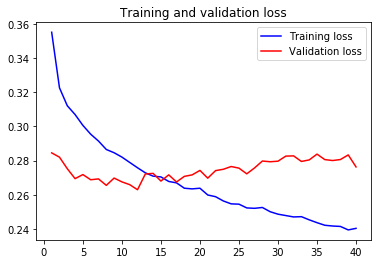

In [8]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 결과 분석

- 아직 충분히 overfitting되지 않았기 때문에 검증 손실을 향상시키기 위해 층의 크기를 늘릴 수 있지만 계산비용이 또 증가함
- 층을 추가한 만큼의 큰 성능 향상이 없었으므로 네트워크의 용량을 늘리는 것이 큰 도움이 되지 않는다고도 볼 수 있음

## 6.3.8 양방향 RNN 사용하기

### 양방향 RNN(Bidirectional RNN)

- **양방향 RNN은 RNN 2개를 사용해 하나는 시간순서, 하나는 시간반대순서로 처리한 후 각 표현을 합치는 것(단방향 RNN이 놓치는 패턴을 감지)**

- 양방향 RNN은 특정 작업에서 기본 RNN보다 좋은 성능을 내며 특히 자연어 처리에서 자주 사용됨

- 참고)여기서 RNN은 순환층(LSTM, GRU등을 포함)을 말함, SimpleRNN만 말하는 것이 아님

### 시간 방향의 설정

- 이 절에서 RNN이 시간 순서대로 시퀀스를 처리하도록 한 것은 근거 없는 결정이었음

- 시간 순서가 성능이 좋을수도 있고, 시간 반대순서가 좋을수도 있음

### 시간 반대순서 시퀀스 성능 테스트 : 기온 예측 문제

- 6.3.5절의 첫 번째 순환 신경망 예제로 테스트
- 제너레이터만 시간 반대방향으로 시퀀스 생성하도록 수정

In [52]:
# 기존의 generator에서 방향만 바꿔줌

# 시간 반대방향 시퀀스 제너레이터

def reverse_generator(data, lookback, delay, step=6, 
              shuffle=False, batch_size=128):
    min_idx = 0
    max_idx = len(data)-delay-1
    
    i = min_idx + lookback
    
    while True:
        if shuffle:
            rows = np.random.randint(i, max_idx, batch_size)
        else:
            if (i+batch_size) >= max_idx:
                rows = np.arange(i, max_idx)
                i = min_idx + lookback
                
            else:
                rows = np.arange(i, i+batch_size)
                i += batch_size
                
        samples = np.zeros((len(rows), lookback//step, data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            samples[j] = data[range(rows[j]-lookback, rows[j], step)]
            targets[j] = data[rows[j]+delay][1]
            
        yield samples[:, ::-1, :], targets
        
lookback = 1440 
delay = 144
step = 6
batch_size = 128

reverse_train_gen = reverse_generator(float_data[:200000],
                                      lookback=lookback,
                                      delay=delay,
                                      step=step,
                                      shuffle=True,
                                      batch_size=batch_size)

reverse_val_gen = reverse_generator(float_data[200000:300000],
                                    lookback=lookback,
                                    delay=delay,
                                    step=step,
                                    batch_size=batch_size)

reverse_test_gen = reverse_generator(float_data[300000:],
                                     lookback=lookback,
                                     delay=delay,
                                     step=step,
                                     batch_size=batch_size)

val_steps = int(np.ceil((300000-200000-lookback-delay-1)/batch_size))
test_steps = int(np.ceil((len(float_data)-300000-lookback-delay-1)/batch_size))

print(val_steps, test_steps)

769 930


In [53]:
# 6.3.5절의 첫 번째 순환 신경망 예제

from tensorflow.keras import models, layers, optimizers

model = models.Sequential()

model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_17 (GRU)                 (None, 32)                4608      
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 33        
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [54]:
model.compile(optimizer=optimizers.RMSprop(), loss='mae')

# train_gen -> reverse_train_gen
# test_gen -> reverse_test_gen
history = model.fit(reverse_train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=reverse_val_gen,
                    validation_steps=val_steps)

Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 19s 37ms/step - loss: 0.4785 - val_loss: 0.4918
Epoch 2/20
500/500 [==============================] - 19s 37ms/step - loss: 0.4480 - val_loss: 0.4811
Epoch 3/20
500/500 [==============================] - 17s 33ms/step - loss: 0.4068 - val_loss: 0.4590
Epoch 4/20
500/500 [==============================] - 19s 38ms/step - loss: 0.3785 - val_loss: 0.4439
Epoch 5/20
500/500 [==============================] - 19s 37ms/step - loss: 0.3525 - val_loss: 0.4285
Epoch 6/20
500/500 [==============================] - 18s 37ms/step - loss: 0.3326 - val_loss: 0.4374
Epoch 7/20
500/500 [==============================] - 19s 37ms/step - loss: 0.3149 - val_loss: 0.4348
Epoch 8/20
500/500 [==============================] - 18s 36ms/step - loss: 0.2988 - val_loss: 0.4648
Epoch 9/20
500/500 [==============================] - 18s 35ms/step - loss: 0.2870 - val_loss: 0.4394
Epoch 10/20
500/500 [=================

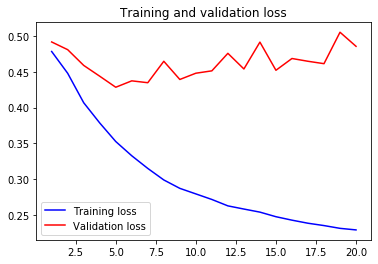

In [55]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 결과 분석

- 기온 예측 문제의 경우, 시간 반대 순서로 테스트 해 본 결과 상식 수준의 기준점보다도 성능이 낮으므로 시간 순서대로 처리하는 것이 좋음

- 이는 최근에 가까운 날씨 데이터일수록 더 예측에 유용(상식 수준의 기준점이 강력한 이유)하며 GRU층이 과거보다 최근의 내용을 더 잘 기억하기 때문에 이러한 결과가 나왔다고 볼 수 있음

### 시간 반대순서 시퀀스 성능 테스트 : 자연어 처리 문제

- 문장을 이해하는데 단어의 중요성은 단어의 위치에 따라 결정되지 않음(자연어 처리 문제)

- 6.2절의 IMDB 예제로 테스트

In [62]:
from keras.datasets import imdb
from keras.preprocessing import sequence

# 특성으로 사용할 단어 수
max_features = 10000

# 문자 길이 (500개의 단어)
maxlen = 500

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

x_train = [x[::-1] for x in x_train]
x_test = [x[::-1] for x in x_test]

# 500의 문자 길이(timesteps=500)를 가진 시퀀스로 변환
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(25000, 500) (25000,)
(25000, 500) (25000,)


In [71]:
# 6.2절의 IMDB 예제

from tensorflow.keras import models, layers, optimizers

model = models.Sequential()

model.add(layers.Embedding(max_features, 32))
model.add(layers.LSTM(32))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
lstm_11 (LSTM)               (None, 32)                8320      
_________________________________________________________________
dense_28 (Dense)             (None, 1)                 33        
Total params: 328,353
Trainable params: 328,353
Non-trainable params: 0
_________________________________________________________________


In [72]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['acc'])


history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s 283us/sample - loss: 0.5770 - acc: 0.7051 - val_loss: 0.4291 - val_acc: 0.8066
Epoch 2/10
20000/20000 [==============================] - 4s 207us/sample - loss: 0.3471 - acc: 0.8644 - val_loss: 0.4328 - val_acc: 0.8058
Epoch 3/10
20000/20000 [==============================] - 4s 201us/sample - loss: 0.2809 - acc: 0.8958 - val_loss: 0.3241 - val_acc: 0.8682
Epoch 4/10
20000/20000 [==============================] - 4s 206us/sample - loss: 0.2295 - acc: 0.9162 - val_loss: 0.3713 - val_acc: 0.8372
Epoch 5/10
20000/20000 [==============================] - 4s 206us/sample - loss: 0.2022 - acc: 0.9278 - val_loss: 0.3835 - val_acc: 0.8298
Epoch 6/10
20000/20000 [==============================] - 4s 197us/sample - loss: 0.1779 - acc: 0.9384 - val_loss: 0.3807 - val_acc: 0.8750
Epoch 7/10
20000/20000 [==============================] - 4s 204us/sample - loss: 0.1650 - acc: 0.9430 - val_lo

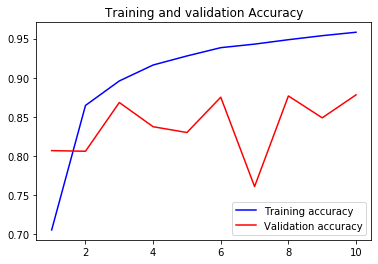

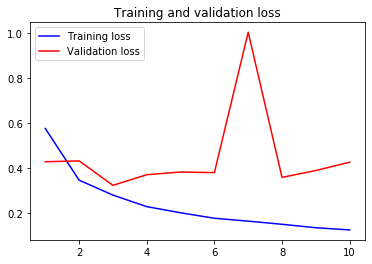

In [73]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title("Training and validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()


plt.show()

#### 결과 분석

- 시간 순서로 훈련한 모델과 거의 동일한 성능을 보임(언어를 이해하는데 단어의 순서가 중요하지만 결정적이지는 않다는 가정을 뒷받침 하는 결과)

- 시간 반대 순서로 훈련하는 것이 의미가 있음(**새로운 데이터의 표현을 얻은 셈**)

### 양방향 RNN의 아이디어

- **머신 러닝에서 다른 표현이 유용할 경우, 사용할 가치가 있으며 이러한 표현이 많을 수록 좋음**
    - 데이터를 바라보는 새로운 시각을 제공
    - 다른 방식에서는 놓칠 수 있는 데이터의 특징을 잡아낼 수 있음
    
    
- 양방향 RNN은 이런 아이디어를 사용해 시퀀스를 양쪽방향으로 바라보며 성능을 향상시킴(앙상블 개념)

### 케라스의 양방향 RNN

- 케라스에서는 `Bidirectional` 층을 사용해 양방향 RNN을 만듦

#### `Bidirectional`클래스

- `Bidirectional`클래스는 첫번째 매개변수로 순환 층의 객체를 전달받음

- 전달 받은 순환 층의 객체와 동일한 새로운 객체를 만든 후 각각 시간순서, 시간반대순서로 입력 시퀀스를 처리

- 두 결과를 합친 후 다음 층으로 전달(덧셈 또는 연결)

### 양방향 RNN 예제 1. 영화 리뷰 분류 문제

In [74]:
# 6.2절의 IMDB 예제

from tensorflow.keras import models, layers, optimizers

model = models.Sequential()

model.add(layers.Embedding(max_features, 32))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 32)          320000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 64)                16640     
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 65        
Total params: 336,705
Trainable params: 336,705
Non-trainable params: 0
_________________________________________________________________


In [75]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['acc'])


history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 11s 529us/sample - loss: 0.5640 - acc: 0.7127 - val_loss: 0.4521 - val_acc: 0.8210
Epoch 2/10
20000/20000 [==============================] - 8s 394us/sample - loss: 0.3463 - acc: 0.8680 - val_loss: 0.3759 - val_acc: 0.8364
Epoch 3/10
20000/20000 [==============================] - 8s 385us/sample - loss: 0.2796 - acc: 0.8972 - val_loss: 0.3073 - val_acc: 0.8852
Epoch 4/10
20000/20000 [==============================] - 8s 400us/sample - loss: 0.2438 - acc: 0.9119 - val_loss: 0.4010 - val_acc: 0.8434
Epoch 5/10
20000/20000 [==============================] - 8s 395us/sample - loss: 0.2093 - acc: 0.9257 - val_loss: 0.3760 - val_acc: 0.8462
Epoch 6/10
20000/20000 [==============================] - 8s 392us/sample - loss: 0.1851 - acc: 0.9366 - val_loss: 0.3556 - val_acc: 0.8812
Epoch 7/10
20000/20000 [==============================] - 8s 387us/sample - loss: 0.1713 - acc: 0.9416 - val_l

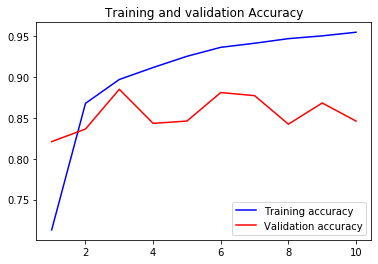

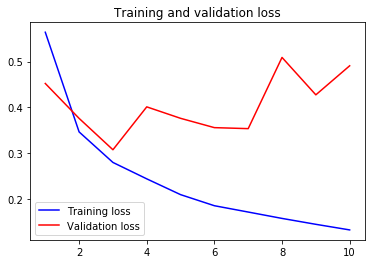

In [76]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title("Training and validation Accuracy")
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()


plt.show()

#### 결과 분석

- 검증 정확도가 88% 정도로 조금 상승
- 하지만 overfitting이 조금 더 일찍 일어남
    - 양방향이 단방향보다 모델 파라미타거 2배 많아서 이런 결과가 나타남
    - regularization을 적용하면 양방향 순환층을 이용하는 것이 더 결과가 좋을 것으로 보임

### 양방향 RNN 예제 2. 기온 예측 문제

In [77]:
# 6.3.5절의 첫 번째 순환 신경망 예제에 적용

from tensorflow.keras import models, layers, optimizers

model = models.Sequential()

model.add(layers.Bidirectional(layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=optimizers.RMSprop(), loss='mae')
history = model.fit(train_gen,
                    steps_per_epoch=500,
                    epochs=20,
                    validation_data=val_gen,
                    validation_steps=val_steps)

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 64)                9216      
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 65        
Total params: 9,281
Trainable params: 9,281
Non-trainable params: 0
_________________________________________________________________
Train for 500 steps, validate for 769 steps
Epoch 1/20
500/500 [==============================] - 27s 54ms/step - loss: 0.2961 - val_loss: 0.2668
Epoch 2/20
500/500 [==============================] - 24s 47ms/step - loss: 0.2740 - val_loss: 0.2650
Epoch 3/20
500/500 [==============================] - 24s 48ms/step - loss: 0.2690 - val_loss: 0.2605
Epoch 4/20
500/500 [==============================] - 25s 50ms/step - loss: 0.2629 - val_loss: 0.2618
Epoch 5/20
500/500 [==============================] - 24s 47m

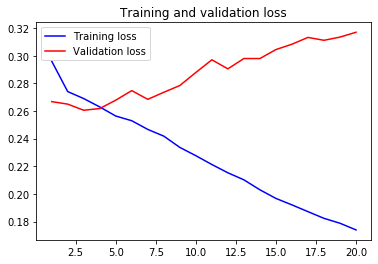

In [78]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and validation loss")
plt.legend()

plt.show()

#### 결과 분석

- 단방향 GRU층과 큰 차이가 없음

- 시간 반대 순서로 처리하는 절반의 경우성능이 좋지 않았기 때문(최근 정보가 더 예측에 중요함)

## 6.3.9 더 나아가서

온도 예측 문제의 성능을 향상시키기 위한 추가 시도 방법들

- 스태킹한 순환 층의 유닛수 조정
- optimizer의 learning rate 조정
- GRU, LSTM층 모두 시도
- 순환 층 위에 용량이 큰 FCN층(Dense층)을 사용


- 마지막으로 모델을 test set으로 평가

## 6.3.10 정리

- 새로운 문제를 해결할 때는 선택한 지표에서 상식 수준의 기준점을 설정하는 것이 좋음


- 계산비용이 높은 모델 전에 간단한 모델을 시도


- 시간 순서가 중요한 데이터에는 순환 층이 적합


- 순환 네트워크의 dropout을 사용하려면 `dropout`과 `recurrent_dropout` 매개 변수 사용


- 스태킹 RNN은 단일 RNN 층보다 더 많은 표현을 학습할 수 있지만 계산 비용이 많이 듦(기계 번역 같은 복잡한 문제에서는 도움이 되지만 간단한 문제에는 도움이 안될 수 있음)


- 양방향 RNN은 최근 정보가 오래된 정보보다 훨씬 의미있는 시퀀스에서는 잘 동작하지 않음(자연어 처리 문제에는 유용함)

### 참고) 자연어 처리에 중요한 2가지 개념

자연어 처리에 깊게 관련된 개념 2가지 개념이므로 이 책에서는 다루지 않음(온도 예측 문제에는 적합하지 않음)

- 순환 어텐션(attention)
- 시퀀스 마스킹(sequence masking)